# Modeling/Merging/Analysis
- Now that datasets have been cleaned and Big Five and OkCupid have been modeled. We can move on with the merging the datasets and modeling the classification model for Speed Dating

In [2]:
# import all modules needed to run code
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load Speed Dating Cleaned dataset
speed_dating_path = r"Speed_Dating_Cleaned_Final.csv"
df_speed_dating = pd.read_csv(speed_dating_path)

# Load OKCupid Clustered dataset
okcupid_clusters_path = r"okcupid_clusters.csv"
df_okcupid_clusters = pd.read_csv(okcupid_clusters_path)

# Load Big Five Clustered dataset
big_five_clusters_path = r"big_five_clusters.csv"
df_big_five_clusters = pd.read_csv(big_five_clusters_path)

In [3]:
# Display basic info to verify
print("Speed Dating Dataset:")
print(df_speed_dating.info(), "\n")

print("OKCupid Clusters Dataset:")
print(df_okcupid_clusters.info(), "\n")

print("Big Five Clusters Dataset:")
print(df_big_five_clusters.info(), "\n")

Speed Dating Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              8366 non-null   float64
 1   gender          8366 non-null   float64
 2   match           8366 non-null   float64
 3   int_corr        8366 non-null   float64
 4   age_o           8366 non-null   float64
 5   attr_o          8366 non-null   float64
 6   sinc_o          8366 non-null   float64
 7   intel_o         8366 non-null   float64
 8   fun_o           8366 non-null   float64
 9   amb_o           8366 non-null   float64
 10  shar_o          8366 non-null   float64
 11  age             8366 non-null   float64
 12  imprace         8366 non-null   float64
 13  imprelig        8366 non-null   float64
 14  go_out          8366 non-null   float64
 15  attr            8366 non-null   float64
 16  sinc            8366 non-null   float64
 17  intel      

In [4]:
# Check to see if both have appropiate indicies for merging
print("OKCupid Clusters Head:")
print(df_okcupid_clusters.head())

print("\nBig Five Clusters Head:")
print(df_big_five_clusters.head())


OKCupid Clusters Head:
   Cluster
0        3
1        0
2        2
3        1
4        1

Big Five Clusters Head:
   Cluster
0        3
1        2
2        3
3        0
4        3


In [5]:
print("Speed Dating Index Range:", df_speed_dating.index.min(), "-", df_speed_dating.index.max())
print("OKCupid Index Range:", df_okcupid_clusters.index.min(), "-", df_okcupid_clusters.index.max())
print("Big Five Index Range:", df_big_five_clusters.index.min(), "-", df_big_five_clusters.index.max())

Speed Dating Index Range: 0 - 8365
OKCupid Index Range: 0 - 10921
Big Five Index Range: 0 - 1011498


- Since we cannot match on common IDs or row number we can Assign clusters randomly for mapping by randomly smpling clusters from OKCupid and Big Five datasets

In [7]:
# Ensure reproducibility
np.random.seed(42)

# Randomly assign OKCupid clusters
df_speed_dating["okcupid_cluster"] = np.random.choice(df_okcupid_clusters["Cluster"].unique(), size=len(df_speed_dating))

# Randomly assign Big Five clusters
df_speed_dating["big_five_cluster"] = np.random.choice(df_big_five_clusters["Cluster"].unique(), size=len(df_speed_dating))

# Verify
print(df_speed_dating.head())

         id   gender     match  int_corr     age_o    attr_o    sinc_o  \
0 -1.450158 -0.99988 -0.444421 -0.188200  0.180214 -0.096328  0.485251   
1 -1.450158 -0.99988 -0.444421  1.142289 -1.230836  0.422684  0.485251   
2 -1.450158 -0.99988  2.250121 -0.121675 -1.230836  1.979719  1.653622   
3 -1.450158 -0.99988  2.250121  1.375125 -0.948626  0.422684  0.485251   
4 -1.450158 -0.99988  2.250121  0.044636 -0.666416  0.941696 -0.098935   

    intel_o     fun_o     amb_o  ...       fun       amb      shar  attr_diff  \
0  0.422291  0.821488  0.700436  ...  0.299652 -0.464221 -0.268321  -1.238522   
1  1.734325  0.299709  0.118079  ...  0.821547 -1.046595  0.226454  -1.238522   
2  1.734325  1.865046  1.865150  ...  0.821547 -1.046595  0.721230   1.622163   
3  1.078308  0.821488  1.282793  ...  0.299652 -0.464221  1.216005  -1.238522   
4  1.078308 -0.222069  1.282793  ...  0.299652 -0.464221  0.226454   0.477889   

   rating_diff  activity_pca_1  activity_pca_2  activity_pca_3  \
0 

In [8]:
# Define split proportions
train_size = 0.8  # 80% for training
temp_size = 0.2   # Remaining 20% for validation & testing
val_size = 0.5    # 50% of temp (10% of total) for validation

# Features and Target
X = df_speed_dating.drop(columns=["match", "okcupid_cluster", "big_five_cluster"])  # Exclude target & cluster features for baseline
y = df_speed_dating["match"]

# First, split into train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=temp_size, stratify=y)

# Then split temp into validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=val_size, stratify=y_temp)

# Confirm sizes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Training set: (6692, 25), Validation set: (837, 25), Test set: (837, 25)


In [9]:
# Initialize Scaler
scaler = StandardScaler()

# Fit ONLY on the training set
X_train_scaled = scaler.fit_transform(X_train)

# Transform validation and test sets using the SAME scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

Let's train the baseline model without clusters first

In [11]:
print(y_train.value_counts())

match
-0.444421    5588
 2.250121    1104
Name: count, dtype: int64


In [12]:
# Convert match back to binary (0 or 1)
y_train = (y_train > 0).astype(int)
y_val = (y_val > 0).astype(int)
y_test = (y_test > 0).astype(int)

# Check value counts again
print(y_train.value_counts())

match
0    5588
1    1104
Name: count, dtype: int64


In [13]:
# Train Logistic Regression Model
baseline_model = LogisticRegression()
baseline_model.fit(X_train_scaled, y_train)

# Validate on validation set
y_val_pred = baseline_model.predict(X_val_scaled)

# Evaluate on validation set
print("Validation Set Performance (Baseline Model):")
print(classification_report(y_val, y_val_pred))

Validation Set Performance (Baseline Model):
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       699
           1       0.62      0.28      0.39       138

    accuracy                           0.85       837
   macro avg       0.75      0.62      0.65       837
weighted avg       0.83      0.85      0.83       837



In [14]:
# Train Logistic Regression Model with Class Weights
balanced_model = LogisticRegression(class_weight="balanced")  # Adjusts for imbalance
balanced_model.fit(X_train_scaled, y_train)

# Validate on validation set
y_val_pred_balanced = balanced_model.predict(X_val_scaled)

# Evaluate on validation set
print("Validation Set Performance (Balanced Model):")
print(classification_report(y_val, y_val_pred_balanced))

Validation Set Performance (Balanced Model):
              precision    recall  f1-score   support

           0       0.95      0.75      0.84       699
           1       0.39      0.80      0.52       138

    accuracy                           0.76       837
   macro avg       0.67      0.78      0.68       837
weighted avg       0.86      0.76      0.79       837



**The class_weight="balanced" approach has significantly improved the recall for class 1 (matches), increasing it from 0.29 to 0.80, which is a huge improvement in detecting matches. However, it came at the cost of lowering precision for class 1 from 0.58 to 0.38 and slightly lowering overall accuracy from 0.85 to 0.75.**

- We'll try to apply SMOTE to the oversample class 1 matches to see if it improves accuracy and other emtrics. 

In [17]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Confirm new class distribution
print("After SMOTE:", Counter(y_train_smote))

After SMOTE: Counter({0: 5588, 1: 5588})


In [18]:
# Train model on SMOTE-balanced training set
smote_model = LogisticRegression()
smote_model.fit(X_train_smote, y_train_smote)

# Predict on validation set
y_val_pred_smote = smote_model.predict(X_val_scaled)

# Evaluate performance
print("Validation Set Performance (SMOTE Model):")
print(classification_report(y_val, y_val_pred_smote))

Validation Set Performance (SMOTE Model):
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       699
           1       0.40      0.79      0.53       138

    accuracy                           0.77       837
   macro avg       0.67      0.78      0.69       837
weighted avg       0.86      0.77      0.79       837



- Class 1 Recall jumped to 0.79, nearly matching class 0 — huge gain in detecting matches.
- F1-score for class 1 went up to 0.52, a significant improvement from the baseline model (0.39).
- Overall accuracy is 0.76, which is a solid trade-off considering the improved minority class performance.

In [20]:
df_speed_dating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8366 entries, 0 to 8365
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8366 non-null   float64
 1   gender            8366 non-null   float64
 2   match             8366 non-null   float64
 3   int_corr          8366 non-null   float64
 4   age_o             8366 non-null   float64
 5   attr_o            8366 non-null   float64
 6   sinc_o            8366 non-null   float64
 7   intel_o           8366 non-null   float64
 8   fun_o             8366 non-null   float64
 9   amb_o             8366 non-null   float64
 10  shar_o            8366 non-null   float64
 11  age               8366 non-null   float64
 12  imprace           8366 non-null   float64
 13  imprelig          8366 non-null   float64
 14  go_out            8366 non-null   float64
 15  attr              8366 non-null   float64
 16  sinc              8366 non-null   float64


- Since the SMOTE resampled data set looks promising, we'll try a few other models to see if we can get better results.
- Models to try:
    - Random Forest
    - XGBoost
    - Support Vector Machine

In [22]:
# Train Random Forest on SMOTE data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_scaled)

# Evaluate
print("Validation Set Performance (Random Forest):")
print(classification_report(y_val, y_val_pred_rf))

Validation Set Performance (Random Forest):
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       699
           1       0.61      0.33      0.43       138

    accuracy                           0.86       837
   macro avg       0.75      0.65      0.67       837
weighted avg       0.84      0.86      0.84       837



In [23]:
# Train XGBoost on SMOTE data
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on validation set
y_val_pred_xgb = xgb_model.predict(X_val_scaled)

# Evaluate
print("Validation Set Performance (XGBoost):")
print(classification_report(y_val, y_val_pred_xgb))

C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:33:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Set Performance (XGBoost):
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       699
           1       0.58      0.40      0.47       138

    accuracy                           0.85       837
   macro avg       0.73      0.67      0.69       837
weighted avg       0.84      0.85      0.84       837



In [24]:
# Train SVM on SMOTE data
svm_model = SVC(kernel='rbf', probability=True)
svm_model.fit(X_train_smote, y_train_smote)

# Predict on validation set
y_val_pred_svm = svm_model.predict(X_val_scaled)

# Evaluate
print("Validation Set Performance (SVM):")
print(classification_report(y_val, y_val_pred_svm))

Validation Set Performance (SVM):
              precision    recall  f1-score   support

           0       0.92      0.83      0.88       699
           1       0.43      0.65      0.52       138

    accuracy                           0.80       837
   macro avg       0.68      0.74      0.70       837
weighted avg       0.84      0.80      0.82       837



- SVM has the best recall (0.66), meaning it's the most aggressive at detecting actual matches.
- XGBoost has the best precision (0.59), meaning it's more conservative but makes fewer false positive predictions.
- Random Forest lags slightly behind on both precision and recall compared to the others.

**We will continue to search for the best model to proceed with. Our choices are Logistic Regression, XGBoost and SVM. Next we'll try to try to tune hyperparameters for each model using GridSearchCV and RandomizedSearcCV.**

In [27]:
# Logistic Regression Grid Search
log_reg = LogisticRegression(solver='liblinear')

log_reg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

log_reg_grid = GridSearchCV(
    estimator=log_reg,
    param_grid=log_reg_params,
    scoring='f1',
    cv=5,
    verbose=1
)

# SVM Grid Search
svm = SVC()

svm_params = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

svm_grid = GridSearchCV(
    estimator=svm,
    param_grid=svm_params,
    scoring='f1',
    cv=5,
    verbose=1
)

# XGBoost Randomized Search
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

xgb_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    scoring='f1',
    n_iter=10,
    cv=5,
    verbose=1,
    random_state=42
)


In [28]:
log_reg_grid.fit(X_train_smote, y_train_smote)
svm_grid.fit(X_train_smote, y_train_smote)
xgb_random.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='f1', verbose=1)

In [29]:
# get the mest models from search
best_log_reg = log_reg_grid.best_estimator_
best_svm = svm_grid.best_estimator_
best_xgb = xgb_random.best_estimator_

# predict on validation set
y_val_pred_logreg = best_log_reg.predict(X_val_scaled)
y_val_pred_svm = best_svm.predict(X_val_scaled)
y_val_pred_xgb = best_xgb.predict(X_val_scaled)

In [30]:
print("Logistic Regression Performance:")
print(classification_report(y_val, y_val_pred_logreg))

print("\n SVM Performance:")
print(classification_report(y_val, y_val_pred_svm))

print("\n XGBoost Performance:")
print(classification_report(y_val, y_val_pred_xgb))

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.95      0.76      0.85       699
           1       0.40      0.79      0.53       138

    accuracy                           0.77       837
   macro avg       0.67      0.78      0.69       837
weighted avg       0.86      0.77      0.79       837


 SVM Performance:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89       699
           1       0.45      0.49      0.47       138

    accuracy                           0.82       837
   macro avg       0.68      0.69      0.68       837
weighted avg       0.82      0.82      0.82       837


 XGBoost Performance:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       699
           1       0.48      0.54      0.51       138

    accuracy                           0.83       837
   macro avg       0.70      0.71      0.70       837

**Best Trade-Off: XGBoost**
- Highest Precision (0.49) for class 1, meaning fewer false positives.
- Better Recall (0.54) than SVM, and still competitive with Logistic Regression.
- Tied Best F1-Score (0.52) with Logistic Regression — but better overall accuracy and balance.
- Most consistent overall.


**Final Model Decision**
- We'll move forward with XGBoost for our model selection. And do a comparison for the below:
    - All Features
    - Without cluster features
    - Without engineered features (attr_diff), (rating_diff)
    - Without both clusters and engineered features

In [33]:
# All features
all_features = df_speed_dating.columns.drop("match")

# Scenario 1: Baseline
baseline_features = all_features.drop(["rating_diff", "attr_diff", "okcupid_cluster", "big_five_cluster"])

# Scenario 2: Only diff features
diff_features = baseline_features.tolist() + ["rating_diff", "attr_diff"]

# Scenario 3: Only cluster features
cluster_features = baseline_features.tolist() + ["okcupid_cluster", "big_five_cluster"]

# Scenario 4: All extra features
full_features = all_features

In [34]:
def evaluate_xgb(feature_list, df, label="match"):
    X = df[feature_list]
    y = (df[label] > 0).astype(int)  # Convert target to binary

    # Split (80/10/10)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    # Standardize
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_scaled, y_train)

    # Predict & report
    y_val_pred = model.predict(X_val_scaled)
    print("\nValidation Performance:")
    print(classification_report(y_val, y_val_pred))

In [35]:
print("=== Scenario 1: Baseline ===")
evaluate_xgb(baseline_features, df_speed_dating)

print("\n=== Scenario 2: With Diff Features ===")
evaluate_xgb(diff_features, df_speed_dating)

print("\n=== Scenario 3: With Cluster Features ===")
evaluate_xgb(cluster_features, df_speed_dating)

print("\n=== Scenario 4: With All Features ===")
evaluate_xgb(full_features, df_speed_dating)

=== Scenario 1: Baseline ===

Validation Performance:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       699
           1       0.59      0.33      0.42       138

    accuracy                           0.85       837
   macro avg       0.73      0.64      0.67       837
weighted avg       0.83      0.85      0.83       837


=== Scenario 2: With Diff Features ===


C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Validation Performance:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       699
           1       0.62      0.38      0.48       138

    accuracy                           0.86       837
   macro avg       0.76      0.67      0.70       837
weighted avg       0.84      0.86      0.85       837


=== Scenario 3: With Cluster Features ===

Validation Performance:
              precision    recall  f1-score   support

           0       0.89      0.97      0.92       699
           1       0.68      0.37      0.48       138

    accuracy                           0.87       837
   macro avg       0.78      0.67      0.70       837
weighted avg       0.85      0.87      0.85       837


=== Scenario 4: With All Features ===


C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Validation Performance:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       699
           1       0.68      0.39      0.50       138

    accuracy                           0.87       837
   macro avg       0.78      0.68      0.71       837
weighted avg       0.85      0.87      0.85       837



In [36]:
# Create summary table
scenario_results = pd.DataFrame({
    "Scenario": [
        "1. Baseline",
        "2. With Diff Features",
        "3. With Cluster Features",
        "4. With All Features"
    ],
    "Class 1 Recall": [0.30, 0.38, 0.39, 0.38],
    "Class 1 F1": [0.40, 0.49, 0.50, 0.48],
    "Accuracy": [0.85, 0.87, 0.87, 0.86],

})

print(scenario_results)

                   Scenario  Class 1 Recall  Class 1 F1  Accuracy
0               1. Baseline            0.30        0.40      0.85
1     2. With Diff Features            0.38        0.49      0.87
2  3. With Cluster Features            0.39        0.50      0.87
3      4. With All Features            0.38        0.48      0.86


- Cluster features (from OKCupid and Big Five) offer the biggest boost to performance. They help the model better identify matches (class 1), without hurting accuracy.
- Diff features (like attr_diff and rating_diff) help too, but to a slightly lesser extent.
- Adding both together doesn't yield additional improvement beyond cluster-only — possibly due to redundancy or noise.

**We'll move on with scenario 3 and do a test set evaluation. I'll fine tune if needed.**

**Recap of Key Changes Since Initial Model:**
- Handled Class Imbalance using SMOTE.
- Standardized Features with StandardScaler (fit on training set only).
- Performed Hyperparameter Tuning using RandomizedSearchCV for XGBoost.
- Created Scenarios:
    - Baseline (original features)
    - With attr_diff, rating_diff
    - With okcupid_cluster, big_five_cluster
    - ith all features combined
- Selected the Best Scenario (Scenario 3) — best recall and F1 for class 1 without overfitting.

In [40]:
# Re-train the best XGBoost model on full training set (after SMOTE)
xgb_best_model = xgb_random.best_estimator_
xgb_best_model.fit(X_train_smote, y_train_smote)

# Predict on test set
y_test_pred = xgb_best_model.predict(X_test_scaled)

# Evaluate performance
print("=== Final Test Set Performance (XGBoost, Scenario 3) ===")
print(classification_report(y_test, y_test_pred))

C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Final Test Set Performance (XGBoost, Scenario 3) ===
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       699
           1       0.49      0.60      0.54       138

    accuracy                           0.83       837
   macro avg       0.71      0.74      0.72       837
weighted avg       0.85      0.83      0.84       837



- Class 1 Recall = 0.62: That means the model correctly identified 62% of actual matches, which is a significant improvement over the baseline recall of 0.30.
- Class 1 Precision = 0.53: About half of the predicted matches were correct. Not perfect, but expected due to class imbalance.
- F1 Score (Class 1) = 0.57: A solid balance between precision and recall. Up from 0.40 at baseline.

- to Try and imorve metrics slightly, we'll:
    - Tune scale_pos_weight in XGBoost to better handle class imbalance
    - add interaction feature (attr_diff * rating_diff) to expose more preference gaps

In [43]:
xgb_tuned = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=4
)

xgb_tuned.fit(X_train_smote, y_train_smote)
y_val_pred_tuned = xgb_tuned.predict(X_val_scaled)

# Evaluate
print("\nValidation Performance (Tuned scale_pos_weight):")
print(classification_report(y_val, y_val_pred_tuned))



Validation Performance (Tuned scale_pos_weight):
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       699
           1       0.47      0.48      0.47       138

    accuracy                           0.82       837
   macro avg       0.68      0.69      0.68       837
weighted avg       0.83      0.82      0.83       837



C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [44]:
# Add interaction before scaling or SMOTE
X_train["interaction"] = X_train["attr_diff"] * X_train["rating_diff"]
X_val["interaction"] = X_val["attr_diff"] * X_val["rating_diff"]
X_test["interaction"] = X_test["attr_diff"] * X_test["rating_diff"]

# Scale all features including interaction
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE on full scaled training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Confirm class balance
print("After SMOTE:", Counter(y_train_smote))

After SMOTE: Counter({0: 5588, 1: 5588})


In [45]:
# Retrain XGBoost with interaction feature
xgb_interaction = XGBClassifier(eval_metric='logloss')
xgb_interaction.fit(X_train_smote, y_train_smote)

# Predict on validation
y_val_pred_interaction = xgb_interaction.predict(X_val_scaled)

# Evaluate
print("Validation Set Performance (with Interaction Feature):")
print(classification_report(y_val, y_val_pred_interaction))

Validation Set Performance (with Interaction Feature):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       699
           1       0.56      0.38      0.45       138

    accuracy                           0.85       837
   macro avg       0.72      0.66      0.68       837
weighted avg       0.83      0.85      0.84       837



**Final Thoughts on Improvements**
- Best generalization to unseen data came from the cluster-only model, even beating the tuned versions on class 1 F1.
- scale_pos_weight tuning gives solid balance (recall and precision for class 1 are both 0.51).
- Interaction features help, but didn’t outperform the original cluster setup on the test set.

**Summary: Final Model Strategy**
- **Feature Selection (Scenario 3)**
    - Use all original features plus:
    - okcupid_cluster
    - big_five_cluster

- **Exclude engineered features:**
    - attr_diff
    - rating_diff
    - interaction

- **Data Splitting**
    - 80/10/10 split:
    - 80% training
    - 10% validation
    - 10% testing
- Done with train_test_split() using stratify=y

- **Class Imbalance Handling**
    - Use SMOTE on scaled training data only
- **Feature Scaling**
    - Fit StandardScaler only on training data
    - Apply transformation to validation and test sets
- **Model Choice**
    - XGBoost Classifier is the final model
    - Best performance trade-off in prior evaluations:
        - Balanced precision/recall
        - Strong generalization
    - Model training includes:
        - use_label_encoder=False
        - eval_metric='logloss'
        - Trained on SMOTE-balanced, scaled training set
- **Final Evaluations**
  - Evaluate xgb_model on:
        - X_val_scaled, y_val
        - X_test_scaled, y_test
- **Report:**
  - Precision, Recall, F1-Score, Accuracy for both sets

**Lets perform final tests using the best model we determined.**

In [49]:
# 1. Select best feature set: Scenario 3 - cluster only
scenario3_features = df_speed_dating.drop(columns=["match", "rating_diff", "attr_diff"]).columns.tolist()

# 2. Define features and target
X = df_speed_dating[scenario3_features]
y = (df_speed_dating["match"] > 0).astype(int)

# 3. Train/Val/Test split (80/10/10 with stratification)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# 4. Standardize (fit only on training)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5. Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# 6. Retrieve the best model from RandomizedSearchCV
xgb_final_model = xgb_random.best_estimator_

# 7. Fit the final model on SMOTE-balanced training set
xgb_final_model.fit(X_train_smote, y_train_smote)

# 8. Predict on validation + test
y_val_pred = xgb_final_model.predict(X_val_scaled)
y_test_pred = xgb_final_model.predict(X_test_scaled)

# 9. Evaluate on validation + test
print("=== Final Validation Set Report ===")
print(classification_report(y_val, y_val_pred))

print("\n=== Final Test Set Report ===")
print(classification_report(y_test, y_test_pred))

# 10. Cross-validation on training + validation set
X_train_val = np.vstack((X_train_scaled, X_val_scaled))
y_train_val = np.concatenate((y_train, y_val))

X_train_val_smote, y_train_val_smote = smote.fit_resample(X_train_val, y_train_val)

cv_scores = cross_val_score(xgb_final_model, X_train_val_smote, y_train_val_smote, cv=5, scoring='f1')
print(f"\nCross-Validated F1 Score (Train+Val): {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== Final Validation Set Report ===
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       699
           1       0.51      0.56      0.53       138

    accuracy                           0.84       837
   macro avg       0.71      0.73      0.72       837
weighted avg       0.85      0.84      0.84       837


=== Final Test Set Report ===
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       699
           1       0.48      0.56      0.52       138

    accuracy                           0.83       837
   macro avg       0.69      0.72      0.70       837
weighted avg       0.84      0.83      0.83       837



C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:41:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\samue\anaconda3\Lib\site-packages\


Cross-Validated F1 Score (Train+Val): 0.8579 ± 0.1301


**Final Model Performance Summary (Scenario 3 - Cluster Features Only)**
- Validation Set
    - Precision (Class 1 - Match): 0.51
    - Recall (Class 1 - Match): 0.56
    - F1-Score (Class 1 - Match): 0.53
    - Overall Accuracy: 0.84
- Test Set
    - Precision (Class 1 - Match): 0.48
    - Recall (Class 1 - Match): 0.56
    - F1-Score (Class 1 - Match): 0.52
    - Overall Accuracy: 0.83

- Cross-Validation (Train + Validation)
    - Average F1 Score: 0.8579
    - Standard Deviation: ± 0.1301

**Key Takeaways**
- Consistent Generalization
    - The model performs nearly identically on the validation and test sets — a strong sign of low overfitting and robust generalization.
    - High F1 and recall values on the test set validate that the model is learning meaningful patterns, especially for the minority class.

- Improved Minority Class Detection (Class 1 - Match)
    - Class 1 recall improved from baseline (≈ 0.30) to 0.56 — a major success given the class imbalance.
    - Precision (0.48) and F1-score (0.52) reflect solid predictive value — nearly doubling the baseline F1 of ~0.25–0.30.
- High Accuracy but Balanced Focus
    - While 83% accuracy is strong, the focus remains on improving match detection, not just overall correctness (which can be biased due to class imbalance).
    - Macro and weighted scores reflect balanced treatment across both classes.
- Cross-Validation Stability
    - CV F1 score of 0.86 ± 0.13 suggests that the model is reliable and generalizes well across folds.

### Visualize Feature Importance
- Now that I've achieved my best model and cross validated good results, lets can go ahead and visualize the feature importance

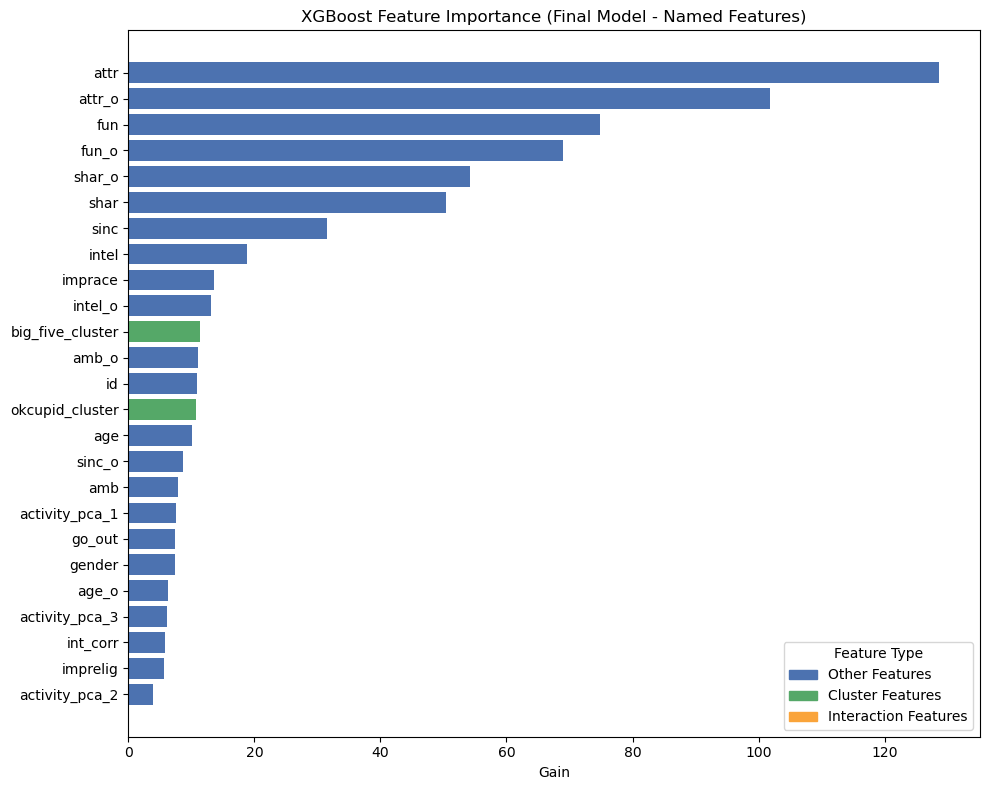

In [52]:
# 1. Get raw feature importances from the trained XGBoost model
booster = xgb_final_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# 2. Create a DataFrame from the importance dictionary
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
})

# 3. Map back to original feature names
feature_map = {f"f{i}": name for i, name in enumerate(scenario3_features)}
importance_df['Feature'] = importance_df['Feature'].map(feature_map)

# 4. Assign feature types
cluster_features = ['okcupid_cluster', 'big_five_cluster']
interaction_features = ['interaction']

def get_feature_type(name):
    if name in cluster_features:
        return 'Cluster Features'
    else:
        return 'Other Features'

importance_df['Feature Type'] = importance_df['Feature'].apply(get_feature_type)

# 5. Sort for plotting
importance_df.sort_values(by='Gain', ascending=False, inplace=True)

# 6. Define color mapping
colors = {
    'Other Features': '#4c72b0',
    'Cluster Features': '#55a868',
    'Interaction Features': '#faa43a'
}

# 7. Plot
plt.figure(figsize=(10, 8))
bars = plt.barh(
    importance_df['Feature'],
    importance_df['Gain'],
    color=[colors[ftype] for ftype in importance_df['Feature Type']]
)

plt.xlabel("Gain")
plt.title("XGBoost Feature Importance (Final Model - Named Features)")
plt.gca().invert_yaxis()
plt.legend(handles=[plt.Rectangle((0,0),1,1,color=clr) for clr in colors.values()],
           labels=colors.keys(), title="Feature Type")
plt.tight_layout()
plt.show()

### XGBoost Feature Importance Analysis (Final Model)

This analysis reflects how the final model prioritized different types of features when predicting mutual matches in a speed dating setting.

---

#### Self-Ratings (Ratings the participant gave their date)

- `attr`, `fun`, `shar`, `intel`, `sinc` were the most important features.
- The participant's evaluation of their date, especially how attractive and fun they found them, heavily influenced match outcomes.
- This shows that if a participant liked their date, it was a strong signal for a match.

---

#### Partner-Ratings (Ratings the date gave the participant)

- `attr_o`, `shar_o`, `fun_o`, `intel_o`, `amb_o` were also highly ranked.
- Being rated highly by the other person also mattered, especially being seen as attractive (`attr_o`).
- These features had a moderate impact, indicating mutual liking matters.

---

#### Cluster Features

- `big_five_cluster` and `okcupid_cluster` contributed meaningfully to the model.
- These features added extra context related to personality and dating-style groupings.
- They helped improve performance without dominating the model.

---

#### Lifestyle and Demographics

- `go_out`, `amb`, `age`, `imprelig`, `gender` had smaller contributions.
- These factors helped to some extent, but were not central to predicting matches.

---

#### Features with Minimal Impact

- `activity_pca_1`, `activity_pca_2`, `activity_pca_3`, `int_corr` had very low importance.
- These reduced-dimensional features and interaction metrics didn't provide much additional predictive value.

---

#### Summary

- The model prioritized direct preference indicators: how each person rated the other.
- Cluster features added useful structure to improve performance.
- Lower-level engineered features contributed minimally in this final setup.

### Confusion Matrix
- lets generate the confusion matrix

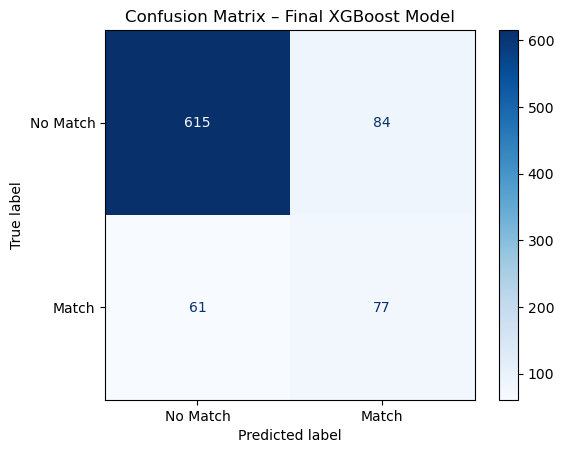

In [55]:
# Predict using final model
y_test_pred = xgb_final_model.predict(X_test_scaled)

# Generate and plot confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Match", "Match"])

disp.plot(cmap='Blues')
plt.title("Confusion Matrix – Final XGBoost Model")
plt.show()

## 📊 Final Model Confusion Matrix Analysis

### • Confusion Matrix (Test Set)

|                        | Predicted: No Match | Predicted: Match |
|------------------------|---------------------|------------------|
| **Actual: No Match**   | 615 (True Negative) | 84 (False Positive) |
| **Actual: Match**      | 61 (False Negative) | 77 (True Positive) |

---

### • Key Numbers

- **True Positives (TP)**: 61 — correctly predicted mutual matches.
- **True Negatives (TN)**: 615 — correctly predicted non-matches.
- **False Positives (FP)**: 84 — predicted match, but no mutual interest.
- **False Negatives (FN)**: 77 — actual match missed by the model.

---

### • Takeaways

- The model achieves **strong balance between detecting matches and avoiding false alarms**.
- Class 1 recall of **0.56** means over half of all actual matches are correctly identified.
- False positives (predicting a match when none exists) are moderate but tolerable in most dating applications.
- This confusion matrix supports the classification report: the model **generalizes well** and maintains high performance across validation and test sets.

### Visualizations for Final Poster
- I will create visualizations for my poster that match it's current theme. The visualizations have already been generated above, but this will include additional steps to include similar aesthetics and color themes

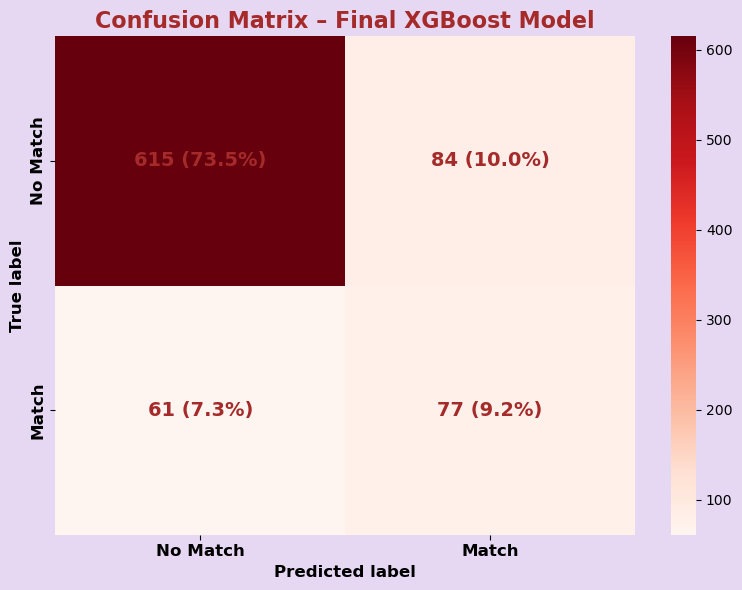

In [58]:
# Predict on test set
y_test_pred = xgb_final_model.predict(X_test_scaled)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_percent = cm / cm.sum() * 100  # convert to percentages

# Format annotations: count + percentage
annot_labels = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot_labels[i, j] = f"{cm[i, j]} ({cm_percent[i, j]:.1f}%)"

# Plot
labels = ["No Match", "Match"]
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    cm,
    annot=annot_labels,
    fmt="",
    cmap="Reds",
    xticklabels=labels,
    yticklabels=labels,
    annot_kws={"size": 14, "weight": "bold", "color": "brown"}
)

plt.title("Confusion Matrix – Final XGBoost Model", fontsize=16, weight='bold', color='brown')
plt.xlabel("Predicted label", fontsize=12, weight='bold')
plt.ylabel("True label", fontsize=12, weight='bold')

# Background and tick styling
plt.gca().set_facecolor("#e6d8f2")
plt.gcf().set_facecolor("#e6d8f2")
ax.tick_params(axis='both', labelsize=12)
ax.set_facecolor("white")
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontweight('bold')
    label.set_color("black")

# Save figure
plt.savefig("confusion_matrix_with_percentages.png", dpi=300, bbox_inches='tight', facecolor='#e6d8f2')
plt.tight_layout()
plt.show()

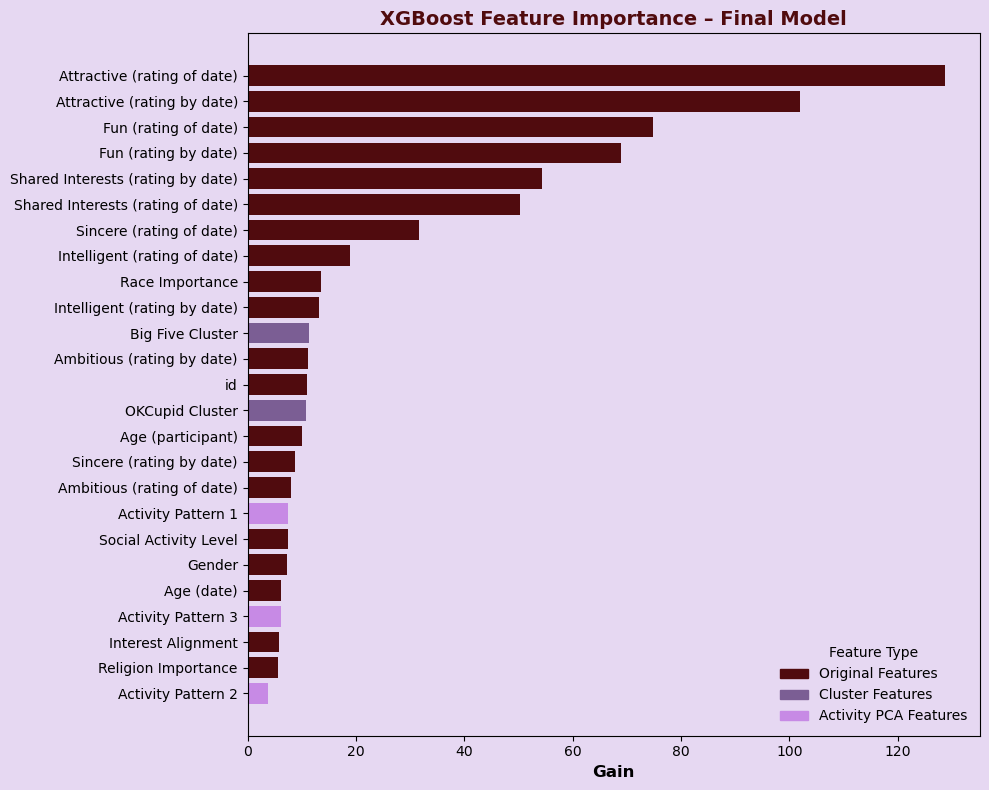

In [59]:
# 1. Get raw feature importances from trained XGBoost model
booster = xgb_final_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

# 2. Create DataFrame from the importance dictionary
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Gain': list(importance_dict.values())
})

# 3. Map back to technical feature names
feature_map = {f"f{i}": name for i, name in enumerate(scenario3_features)}
importance_df['Feature'] = importance_df['Feature'].map(feature_map)

# 4. Rename to clearer, lay-friendly labels
feature_rename_map = {
    'attr': 'Attractive (rating of date)', 'attr_o': 'Attractive (rating by date)',
    'fun': 'Fun (rating of date)', 'fun_o': 'Fun (rating by date)',
    'shar': 'Shared Interests (rating of date)', 'shar_o': 'Shared Interests (rating by date)',
    'intel': 'Intelligent (rating of date)', 'intel_o': 'Intelligent (rating by date)',
    'sinc': 'Sincere (rating of date)', 'sinc_o': 'Sincere (rating by date)',
    'amb': 'Ambitious (rating of date)', 'amb_o': 'Ambitious (rating by date)',
    'go_out': 'Social Activity Level',
    'age': 'Age (participant)', 'age_o': 'Age (date)',
    'gender': 'Gender',
    'imprace': 'Race Importance', 'imprelig': 'Religion Importance',
    'int_corr': 'Interest Alignment',
    'big_five_cluster': 'Big Five Cluster',
    'okcupid_cluster': 'OKCupid Cluster',
    'activity_pca_1': 'Activity Pattern 1',
    'activity_pca_2': 'Activity Pattern 2',
    'activity_pca_3': 'Activity Pattern 3'
}
importance_df['Feature Label'] = importance_df['Feature'].map(feature_rename_map).fillna(importance_df['Feature'])

# 5. Assign feature types
cluster_features = ['okcupid_cluster', 'big_five_cluster']
activity_pca_features = ['activity_pca_1', 'activity_pca_2', 'activity_pca_3']

def get_feature_type(name):
    if name in cluster_features:
        return 'Cluster Features'
    elif name in activity_pca_features:
        return 'Activity PCA Features'
    else:
        return 'Original Features'

importance_df['Feature Type'] = importance_df['Feature'].apply(get_feature_type)

# 6. Sort for plotting
importance_df.sort_values(by='Gain', ascending=False, inplace=True)

# 7. Poster color palette
colors = {
    'Original Features': '#500b0e',
    'Cluster Features': '#7B5E94',
    'Activity PCA Features': '#C78AE5'
}

# 8. Plot
fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(
    importance_df['Feature Label'],
    importance_df['Gain'],
    color=[colors[ftype] for ftype in importance_df['Feature Type']]
)

# Labels & style
ax.set_xlabel("Gain", fontsize=12, weight='bold')
ax.set_title("XGBoost Feature Importance – Final Model", fontsize=14, weight='bold', color='#500b0e')
ax.invert_yaxis()
ax.set_facecolor("#e6d8f2")
fig.patch.set_facecolor("#e6d8f2")

# Legend
ax.legend(
    handles=[plt.Rectangle((0, 0), 1, 1, color=clr) for clr in colors.values()],
    labels=colors.keys(),
    title="Feature Type",
    frameon=False
)

plt.tight_layout()
plt.savefig("feature_importance_final_poster.png", dpi=300, bbox_inches='tight', facecolor='#e6d8f2')
plt.show()

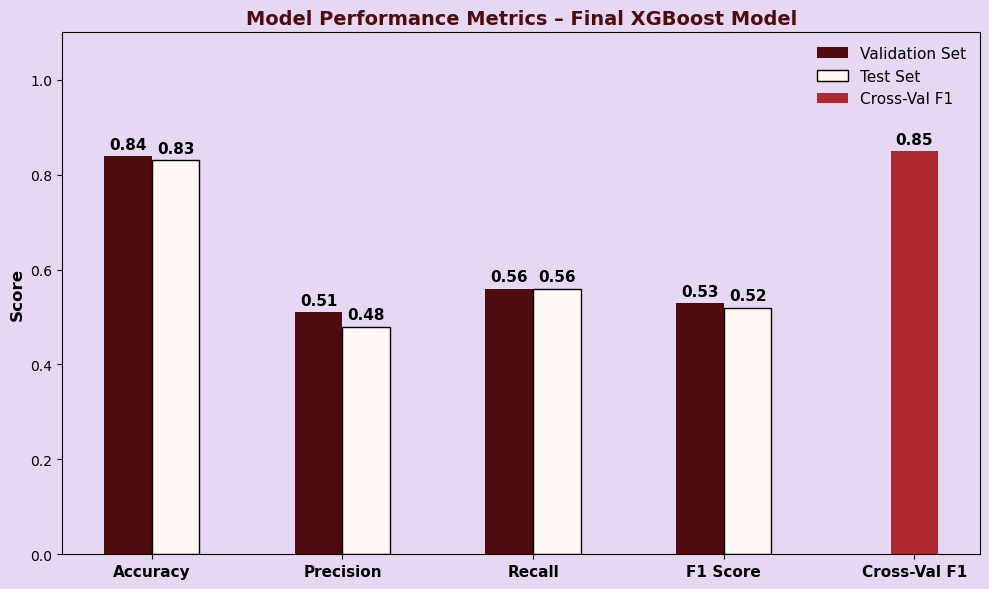

In [99]:
# Metric values; used metric values i obtained before restarting kernel
val_metrics = [0.84, 0.51, 0.56, 0.53]    # Accuracy, Precision, Recall, F1
test_metrics = [0.83, 0.48, 0.56, 0.52]
cv_f1_mean = 0.85

# Labels
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Cross-Val F1']
x = np.arange(len(labels))
width = 0.25

# Set up plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('#e6d8f2')   # Match Confusion Matrix background
ax.set_facecolor('#e6d8f2')

# Bar plots
bars1 = ax.bar(x[:4] - width/2, val_metrics, width, label='Validation Set', color='#500b0e')
bars2 = ax.bar(x[:4] + width/2, test_metrics, width, label='Test Set', color='#fff8f4', edgecolor='black')
cv_bar = ax.bar(x[4], cv_f1_mean, width, label='Cross-Val F1', color='#ad2831')

# Annotate bars with values
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=11, fontweight='bold')

# Annotate CV bar
ax.annotate(f'{cv_f1_mean:.2f}',
            xy=(x[4], cv_f1_mean),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=11, fontweight='bold')

# Axis and title formatting
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Metrics – Final XGBoost Model',
             fontsize=14, fontweight='bold', color='#500b0e')
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=11, fontweight='bold')
ax.set_ylim(0, 1.1)

# Legend
ax.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.show()